slope:  0.009673636363636363


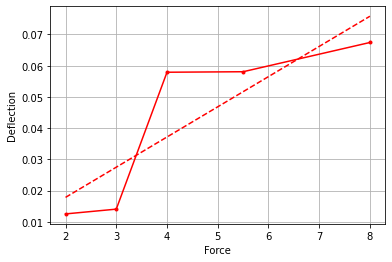

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sympy
import numpy as np
from sympy import pi
from sympy import integrate
import pandas as pd
from scipy.stats import linregress

b,h,theta,P,L,E,I,x,w,M,q,p,A,B,C,D,p0,M0=sympy.symbols('b,h,theta,P,L,E,I,x,w,M,q,p,A,B,C,D,p0,M0')

x_axis = [2, 3, 4, 5.5, 8] # mass of various loads (oz)
xt = np.array(x_axis)
y_axis = [0.0125, 0.01403, 0.0579, 0.05806, 0.06743] # deflection numbers for rigid cardboard (m)
yt = np.array(y_axis)
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)
def a_predict(x_axis):
    return intercept + slope*x_axis

x_min, x_max = min(x_axis), max(x_axis)
a_min, a_max = a_predict(x_min), a_predict(x_max)

plt.plot(xt, intercept + slope*xt, 'r--')

print("slope: ", slope)
plt.plot(x_axis, y_axis, '.r-')
plt.xlabel('Force')
plt.ylabel('Deflection')
plt.grid(True)
plt.show()



In [2]:
def plot_x(w,subs1=None):
    subs1 = subs1 or {}
    w = w.subs(subs1) 
    unit = dict([(item,1) for item in w.atoms(sympy.Symbol) if item!=x])
    unit.update(subs1)
    w_num = w.subs(unit)
    f_w = sympy.lambdify(x,w_num)

    xn = np.r_[0:unit[L]:100j]
    yn = f_w(xn)

    plt.plot(xn,yn)
    plt.axis('equal')

In [3]:
#Computed moment of beam as function of the loading 
b = 0.125 # meters
h = 0.025 # meters
Ixx = (1/12)*b*h**3
Iyy = (1/12)*h*b**3
MaxDeflect = [0.0125, 0.01403, 0.0579, 0.05806, 0.06743]
d = np.array(MaxDeflect)
P = [2, 3, 4, 5.5, 8]
p = np.array(P)
E = ((b**3)*p)/(d * 3*(Ixx))
E2 = ((b**3)*4.5)/(0.041984 * 3*(Ixx)) # 4.5 and 0.041984 are the average weight and deflection respectively
rounded = np.round(E, 2)
print("Young's Modulus:\n", rounded)
rounded2 = np.round(E2, 2)
print("Average Young's Modulus:\n", rounded2)
Stiffness = E2 * Ixx
print("Stiffness:\n", Stiffness)
M_dd = np.dot(p, p) 

Young's Modulus:
 [640000.   855310.05 276338.51 378918.36 474566.22]
Average Young's Modulus:
 428734.76
Stiffness:
 0.06978104754192073


### Improved Dynamics Model

Since the prototype was built to scale, none of the mechanism lengths are changed from the previous assignment.


**Table I. Mechanism Lengths**

| Length | Rigid Body | Measurement (m)
| --- | --- | --- |
| L10 | Yellow | 0.03 |
| L02 | Purple | 0.0689 |
| L42 | Purple | 0.0973 |
| L40 | Purple | 0.0737 |
| L31 | Red | 0.066 |
| L61 | Red | 0.1236 | 
| L63 | Red | 0.0584 |
| L54 | Green | 0.0579 |
| L32 | Orange | 0.0359 |
| L56 | Blue | 0.1004 |
| L5E | Blue | 0.1940 |
| LE6 | Blue | 0.1004 |

**Table II. Mechanism Masses**

| Rigid Body | Mass (kg)
| --- | --- |
| Yellow | 0.000179 |
| Purple | 0.00144 |
| Red | 0.000746 |
| Green | 0.000347 |
| Orange | 0.000215 |
| Blue | 0.00120 |

*Note: The derivation of these mass values is included in the code below. It is based on the weight of cardstock paper.*

Show plots inline and ensure that pynamics is installed.

In [4]:
%matplotlib inline
!pip install pynamics

Import all required packages. Packages related to dynamics are commented out since they are not needed for this assignment, but will be used in the future.

In [5]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body # New for this assignment
from pynamics.dyadic import Dyadic # New for this assignment
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle # New for this assignment
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
from pynamics.constraint import Constraint # New for this assignment
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [6]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants and ground coordinate locations.

In [7]:
# All lengths converted to meters from the previous assignment
# Put all meaured lengths in meters in a list so that if we chose to change these
# in the future, they can all be scaled up or down with a single multiplier
allLengths = [0.03, 0.066, 0.0359, 0.068877, 0.12363, 0.1004, 0.0579, 0.073736, \
              0.0584, 0.0973, 0.1004, 0.19396]

groundCoords = [-0.066, -0.0197, -0.026, 0.069]

# Make a the ground link of the second leg 0.1085m shifted to the right and mirrored
groundCoords__R = [0.066+0.1085, -0.0197, 0.026+0.1085, 0.069]

lengthScale = 1 # Default is 1, means that the measurements in allLengths and groundCoords will be unchanged from above

# Python's fancy way of scaling each element in the list
allLengths = [x * lengthScale for x in allLengths]
groundCoords = [x * lengthScale for x in groundCoords]
groundCoords__R = [x * lengthScale for x in groundCoords__R]

# From Loop Closure Eq. #1
l_10 = Constant(allLengths[0],'l_10',system)
l_31 = Constant(allLengths[1],'l_31',system)
l_32 = Constant(allLengths[2],'l_32',system)
l_02 = Constant(allLengths[3],'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(allLengths[4],'l_61',system)
l_56 = Constant(allLengths[5],'l_56',system)
l_54 = Constant(allLengths[6],'l_54',system)
l_40 = Constant(allLengths[7],'l_54',system)

# Other lengths
l_63 = Constant(allLengths[8],'l_63',system)
l_42 = Constant(allLengths[9],'l_42',system)

# End effector
l_E6 = Constant(allLengths[10],'l_E6',system)
l_5E = Constant(allLengths[11],'l_5E',system)

# Aribtrary length of plate
l_Plate = Constant(0.5,'l_Plate',system)


# Moved the coordinates of the ground link here since they need to be scaled
# the same has lengths
# Ground link coordinates
p2_x = Constant(groundCoords[0],'p2_x',system)
p2_y = Constant(groundCoords[1],'p2_y',system)
p4_x = Constant(groundCoords[2],'p4_x',system)
p4_y = Constant(groundCoords[3],'p4_y',system)

# Points defining ground link
p2_x__R = Constant(groundCoords__R[0],'p2_x__R',system)
p2_y__R = Constant(groundCoords__R[1],'p2_y__R',system)
p4_x__R = Constant(groundCoords__R[2],'p4_x__R',system)
p4_y__R = Constant(groundCoords__R[3],'p4_y__R',system)

# Consider adding the constant angle constraints in the future

Declare all masses of the links

In [8]:
# Found some masses by estimating the length/perimeters in m of the different links in Cree's prototype
# This means the "triangular links" are not considered as rigid bodies, but inside just the sides matter
# Note that the blue and red triangular links actually only include 2 of the three sides in Cree's prototype
allMasses = [0.0300, 0.0359, 0.0579, 0.1244, 0.2004, 0.2399]

# Assuming we use 300 g/m2 heavy cardstock and all links are about 0.02m width by the length
# 0.3 kg * 0.02 m = 0.006 kg * m
massScale = 0.006 # Converts the length or perimeter based mass estimates a more realistic value for cardstock

# Python's fancy way of scaling each element in the list
allMasses = [x * massScale for x in allMasses]

print("Link Masses:", allMasses)

# Left leg
mY = Constant(allMasses[0],'mY',system) # Mass of yellow input link
mO = Constant(allMasses[1],'mO',system) # Mass of orange link
mG = Constant(allMasses[2],'mG',system) # Mass of green link
mR = Constant(allMasses[3],'mR',system) # Mass of red link
mB = Constant(allMasses[4]/2,'mB',system) # Mass of blue link (blue link is cut in half)
mP = Constant(allMasses[5],'mP',system) # Mass of purple groundlink
mB_2 = Constant(allMasses[4]/2,'mB_2',system) # Mass second part of blue link

# Right leg
mY__R = Constant(allMasses[0],'mY__R',system) # Mass of yellow input link
mO__R = Constant(allMasses[1],'mO__R',system) # Mass of orange link
mG__R = Constant(allMasses[2],'mG__R',system) # Mass of green link
mR__R = Constant(allMasses[3],'mR__R',system) # Mass of red link
mB__R = Constant(allMasses[4]/2,'mB__R',system) # Mass of blue link (blue link is cut in half)
mP__R = Constant(allMasses[5],'mP__R',system) # Mass of purple groundlink
mB_2__R = Constant(allMasses[4]/2,'mB_2__R',system) # Mass second part of blue link

# Ground plate (putting an arbitrary mass for now)
mPlate = Constant(0.10,'mPlate',system)

Link Masses: [0.00017999999999999998, 0.0002154, 0.0003474, 0.0007464, 0.0012024, 0.0014394]


Define forces in Newtons

In [9]:
# Gravity in SI units
g = Constant(-9.81,'g',system) # Flipped gravity (gravity points up)

# Experimentally found value for damping
b = Constant(0.0626,'b',system)

# Experimentally found value for stiffness, estimated based on experimentally found Young's Modulus
k = Constant(Stiffness,'k',system)

#### First, defining the inertias

In [10]:
# Diagonal entries of the interia matricies
# For rectangular links: https://www.google.com/search?q=inertia+matrix+of+rectangle&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiskPO74YHvAhXwITQIHa09C7QQ_AUoAXoECBMQAw&biw=1440&bih=764#imgrc=pdWYree46q8xbM
# Where diagonal elements are (1/12 * mass * (lengthSideY^2 - lengthSideZ^2) for example
# The triangular links are bit trickier. I think we can do it in SolidWorks
# Note that the frames are defined in the sections below, but are important for 
# identifying which dimension is x (along frame), y (orthogonal to frame), or z (out of the page)

# TODO: Update these diagonal intertia matrix elements based on the geometry of Cree's prototype

# Inertia of yellow link (rectangle) w.r.t Y frame
Ixx_Y = Constant(1,'Ixx_Y',system)
Iyy_Y = Constant(1,'Iyy_Y',system)
Izz_Y = Constant(1,'Izz_Y',system)

# Inertia of orange link (rectangle)
Ixx_O = Constant(1,'Ixx_O',system)
Iyy_O = Constant(1,'Iyy_O',system)
Izz_O = Constant(1,'Izz_O',system)

# Inertia of green link (rectangle)
Ixx_G = Constant(1,'Ixx_G',system)
Iyy_G = Constant(1,'Iyy_G',system)
Izz_G = Constant(1,'Izz_G',system)

# Inertia of red link (two sides of triangle)
Ixx_R = Constant(1,'Ixx_R',system)
Iyy_R = Constant(1,'Iyy_R',system)
Izz_R = Constant(1,'Izz_R',system)

# Inertia of blue link (two sides of triangle)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)

# Inertia of purple link (three sides of triangle)
Ixx_P = Constant(1,'Ixx_P',system)
Iyy_P = Constant(1,'Iyy_P',system)
Izz_P = Constant(1,'Izz_P',system)

#TODO
# Inertia of pblue link (two sides of triangle)
Ixx_B_2 = Constant(1,'Ixx_B_2',system)
Iyy_B_2 = Constant(1,'Iyy_B_2',system)
Izz_B_2 = Constant(1,'Izz_B_2',system)

# Inertia of the plate
Ixx_Plate = Constant(1,'Ixx_Plate',system)
Iyy_Plate = Constant(1,'Iyy_Plate',system)
Izz_Plate = Constant(1,'Izz_Plate',system)



# Right link
# Inertia of yellow link (rectangle) w.r.t Y frame
Ixx_Y__R = Constant(1,'Ixx_Y__R',system)
Iyy_Y__R = Constant(1,'Iyy_Y__R',system)
Izz_Y__R = Constant(1,'Izz_Y__R',system)

# Inertia of orange link (rectangle)
Ixx_O__R = Constant(1,'Ixx_O__R',system)
Iyy_O__R = Constant(1,'Iyy_O__R',system)
Izz_O__R = Constant(1,'Izz_O__R',system)

# Inertia of green link (rectangle)
Ixx_G__R = Constant(1,'Ixx_G__R',system)
Iyy_G__R = Constant(1,'Iyy_G__R',system)
Izz_G__R = Constant(1,'Izz_G__R',system)

# Inertia of red link (two sides of triangle)
Ixx_R__R = Constant(1,'Ixx_R__R',system)
Iyy_R__R = Constant(1,'Iyy_R__R',system)
Izz_R__R = Constant(1,'Izz_R__R',system)

# Inertia of blue link (two sides of triangle)
Ixx_B__R = Constant(1,'Ixx_B__R',system)
Iyy_B__R = Constant(1,'Iyy_B__R',system)
Izz_B__R = Constant(1,'Izz_B__R',system)

# Inertia of purple link (three sides of triangle)
Ixx_P__R = Constant(1,'Ixx_P__R',system)
Iyy_P__R = Constant(1,'Iyy_P__R',system)
Izz_P__R = Constant(1,'Izz_P__R',system)

# Inertia of pblue link (two sides of triangle)
Ixx_B_2__R = Constant(1,'Ixx_B_2__R',system)
Iyy_B_2__R = Constant(1,'Iyy_B_2__R',system)
Izz_B_2__R = Constant(1,'Izz_B_2__R',system)

#### NOTE: Some additionally code from the kinematics assignment is needed to define the frames, since the center of masses require that the frames be defined.

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [11]:
# Note: All angles are measured CCW


# Left Link
# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

# New angle for the compliant link#
#qNew,qNew_d,qNew_dd = Differentiable('qNew',system) # In the middle of the blue link
qB_2,qB_2_d,qB_2_dd = Differentiable('qB_2',system) # Blue link w.r.t green link frame




# Right leg
# Input state variable (angle of crank on yellow link)
qY__R,qY__R_d,qY__R_dd = Differentiable('qY__R',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO__R,qO__R_d,qO__R_dd = Differentiable('qO__R',system) # Orange link w.r.t base frame
qG__R,qG__R_d,qG__R_dd = Differentiable('qG__R',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR__R,qR__R_d,qR__R_dd = Differentiable('qR__R',system) # Red link w.r.t yellow link frame
qB__R,qB__R_d,qB__R_dd = Differentiable('qB__R',system) # Blue link w.r.t green link frame

# New angle for the compliant link#
#qNew,qNew_d,qNew_dd = Differentiable('qNew',system) # In the middle of the blue link
qB_2__R,qB_2__R_d,qB_2__R_dd = Differentiable('qB_2__R',system) # Blue link w.r.t green link frame




# Plate (rotation of the plate is intentionally omitted)
# Commented out to constrain x
#xPlate,xPlate_d,xPlate_dd = Differentiable('xPlate',system)
yPlate,yPlate_d,yPlate_dd = Differentiable('yPlate',system)

Initial guess for starting positions

In [12]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

# New compliant blue link (second part)
initialvalues[qB_2]=0*pi/180
initialvalues[qB_2_d]=0

# Moving Plate (x = 0, y = -0.08 set as initial position of center)
#initialvalues[xPlate]= 0
#initialvalues[xPlate_d]=0
initialvalues[yPlate]= -0.09
initialvalues[yPlate_d]=0



# Right Leg
# Yellow link w.r.t base
initialvalues[qY__R]=-(180-130)*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY__R_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO__R]=30*pi/180
initialvalues[qO__R_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG__R]=70*pi/180
initialvalues[qG__R_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR__R]=50*pi/180
initialvalues[qR__R_d]=0

# Blue link w.r.t green link frame
initialvalues[qB__R]=115*pi/180
initialvalues[qB__R_d]=0

# New compliant blue link (second part)
initialvalues[qB_2__R]=0*pi/180
initialvalues[qB_2__R_d]=0

Retrieve state variables in the order they are stored in the system

In [13]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

Create the main reference frames, with one cooresponding to each rigid link

In [14]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green
B_2 = Frame('B_2') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE



# Right Leg
# Defined w.r.t to ground
Y__R = Frame('Y__R') # Yellow
O__R = Frame('O__R') # Orange
G__R = Frame('G__R') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R__R = Frame('R__R') # Red w.r.t yellow
B__R = Frame('B__R') # Blue w.r.t green
B_2__R = Frame('B_2__R') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3__R = Frame('R_to_p3__R') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE__R = Frame('B_to_pE__R') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180__R = Frame('B_plus_180__R') # Blue with x axis in opposite direction
R_from_p3__R = Frame('R_from_p3__R') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6__R = Frame('B_from_p6__R') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [15]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [16]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green
# New 
B_2.rotate_fixed_axis_directed(B,[0,0,1],qB_2,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE

# Note that instead of qB+30 degrees, qNew is now there since we have a compliant joint within the blue link
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB_2+qB+30*pi/180,system)
#B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)




# Right leg
# Frames cooresponding to joint angles
Y__R.rotate_fixed_axis_directed(N,[0,0,1],qY__R,system) # Yellow
O__R.rotate_fixed_axis_directed(N,[0,0,1],qO__R,system) # Orange
G__R.rotate_fixed_axis_directed(N,[0,0,1],qG__R,system) # Green
R__R.rotate_fixed_axis_directed(Y__R,[0,0,1],qR__R,system) # Red w.r.t yellow
B__R.rotate_fixed_axis_directed(G__R,[0,0,1],qB__R,system) # Blue w.r.t green
# New 
B_2__R.rotate_fixed_axis_directed(B__R,[0,0,1],qB_2__R,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3__R.rotate_fixed_axis_directed(Y__R,[0,0,1],qR__R-6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE__R.rotate_fixed_axis_directed(G__R,[0,0,1],qB__R+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180__R.rotate_fixed_axis_directed(G__R,[0,0,1],qB__R-180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3__R.rotate_fixed_axis_directed(Y__R,[0,0,1],qR__R+12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE

# Note that instead of qB+30 degrees, qNew is now there since we have a compliant joint within the blue link
B_from_p6__R.rotate_fixed_axis_directed(G__R,[0,0,1],qB_2__R+qB__R-30*pi/180,system)
#B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)


#### Now with the frames defined, the **center of masses** can be considered

In [17]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on purple (ground) link
p0 = 0*N.x # P0 is at the origin
p2 = p2_x*N.x + p2_y*N.y # Coordinates given (in meters)
p4 = p4_x*N.x + p4_y*N.y # Coordinates given (in meters)

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x



# Right leg
# Vectors representing the joint locations w.r.t N frame
# Fixed points on purple (ground) link
p0__R = 0.1085*N.x # P0__R is at the origin plus 0.1085
p2__R = p2_x__R*N.x + p2_y__R*N.y # Coordinates given (in meters)
p4__R = p4_x__R*N.x + p4_y__R*N.y # Coordinates given (in meters)

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0__R = p0__R + l_10*Y__R.x
p3_from_p2__R = p2__R + l_32*O__R.x
p5_from_p4__R = p4__R + l_54*G__R.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1__R = p1_from_p0__R + l_61*R__R.x
pE_from_p5__R = p5_from_p4__R + l_5E*B_to_pE__R.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1__R = p1_from_p0__R + l_31*R_to_p3__R.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6__R = p6_from_p1__R + l_56*B_plus_180__R.x # 180 degress (CCW) from B frame x axis
p6_from_p3__R = p3_from_p2__R + l_63*R_from_p3__R.x # -5.84 degress (CW) from R frame x axis
pE_from_p6__R = p6_from_p3__R + l_E6*B_from_p6__R.x





# Defining the location of the plate
pPlateCenter = 0*N.x + yPlate*N.y

pPlateLeft = pPlateCenter - (l_Plate/2)*N.x
pPlateRight = pPlateCenter + (l_Plate/2)*N.x



# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6, pPlateLeft, pPlateRight, p0__R, p1_from_p0__R, p2__R, p3_from_p2__R, p4__R, p5_from_p4__R, p6_from_p1__R, pE_from_p6__R]
#points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p5]

# Alternative list that works will with Dr. Aukes's plotting function
#points = [p0,p1_from_p0,p3_from_p1,p2,p4,p5_from_p4,p6_from_p1,pE_from_p6,p6_from_p1,p3_from_p1]

In [18]:
# Center of mass for each link, requires information about frames
# For the triangular links, we will need to consider both the x and y components
# since the COM will not be located along any frame like for the straight joints where it is in the middle
# These ones are easy: just in the middle of the length along the correct frame
cmY= l_10/2*Y.x
cmO= p2+l_32/2*O.x
cmG= p4+l_54/2*G.x

# These ones need x and y components (Estimated based on solidworks)
# Note that in the future if dimensions change these need to be updated
cmR=p1_from_p0+0.06*R.x-0.01*R.y
#cmB=p5_from_p4+0.08*B.x+0.03*B.y
cmB=p5_from_p4+0.04*B.x+0.15*B.y
cmP=-0.05*N.x+0.06*N.y

# TODO: update this
#cmB_2=p5_from_p4+0.08*B.x+0.03*B.y
cmB_2=p6_from_p3+0.05*B_2.x+0.15*B_2.y



# Plate
cmPlate = pPlateCenter




# Right leg
cmY__R= l_10/2*Y__R.x
cmO__R= p2__R+l_32/2*O__R.x
cmG__R= p4__R+l_54/2*G__R.x

# These ones need x and y components (Estimated based on solidworks)
# Note that in the future if dimensions change these need to be updated
cmR__R=p1_from_p0__R-0.06*R__R.x-0.01*R__R.y
#cmB=p5_from_p4+0.08*B.x+0.03*B.y
cmB__R=p5_from_p4__R-0.04*B__R.x+0.15*B__R.y
cmP__R= (0.05+0.1085)*N.x+0.06*N.y #CHECK THIS ONE, IT WAS SHIFTED YOYOYO

# TODO: update this
#cmB_2=p5_from_p4+0.08*B.x+0.03*B.y
cmB_2__R=p6_from_p3__R+0.05*B_2__R.x+0.15*B_2__R.y

The next several lines compute the inertia dyadics of each body and define a rigid body on each frame.

In [19]:
# Define the intertia w.r.t to the appropriate frames
IY = Dyadic.build(Y,Ixx_Y,Iyy_Y,Izz_Y)
IO = Dyadic.build(O,Ixx_O,Iyy_O,Izz_O)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IR = Dyadic.build(R,Ixx_R,Iyy_R,Izz_R)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IP = Dyadic.build(N,Ixx_P,Iyy_P,Izz_P) # Purple link is in Newtonian frame
# TODO: Update this
IB_2 = Dyadic.build(B_2,Ixx_B_2,Iyy_B_2,Izz_B_2)
#IPlate = Dyadic.build(IPlate,Ixx_IPlate,Iyy_IPlate,Izz_IPlate) #(decided to use a particle instead)

# Define the bodies that describe the mass/inertial properties of each link
BodyY = Body('BodyY',Y,cmY,mY,IY,system)
BodyO = Body('BodyO',O,cmO,mO,IO,system)
BodyG = Body('BodyG',G,cmG,mG,IG,system)
BodyR = Body('BodyR',R,cmR,mR,IR,system)
BodyB = Body('BodyB',B,cmB,mB,IB,system)
BodyP = Body('BodyP',N,cmP,mP,IP,system)
BodyB_2 = Body('BodyB_2',B_2,cmB_2,mB_2,IB_2,system)




# An alternative approach is to represent each mass as a particle at a certain point
#BodyC = Particle(pCcm,mC,'ParticleC',system)
BodyPlate = Particle(cmPlate,mPlate,'BodyPlate',system)






# Right leg
# Define the intertia w.r.t to the appropriate frames
IY__R = Dyadic.build(Y__R,Ixx_Y__R,Iyy_Y__R,Izz_Y__R)
IO__R = Dyadic.build(O__R,Ixx_O__R,Iyy_O__R,Izz_O__R)
IG__R = Dyadic.build(G__R,Ixx_G__R,Iyy_G__R,Izz_G__R)
IR__R = Dyadic.build(R__R,Ixx_R__R,Iyy_R__R,Izz_R__R)
IB__R = Dyadic.build(B__R,Ixx_B__R,Iyy_B__R,Izz_B__R)
IP__R = Dyadic.build(N,Ixx_P__R,Iyy_P__R,Izz_P__R) # Purple link is in Newtonian frame
IB_2__R = Dyadic.build(B_2__R,Ixx_B_2__R,Iyy_B_2__R,Izz_B_2__R)

#IPlate = Dyadic.build(IPlate,Ixx_IPlate,Iyy_IPlate,Izz_IPlate) #(decided to use a particle instead)

# Define the bodies that describe the mass/inertial properties of each link
BodyY__R = Body('BodyY__R',Y__R,cmY__R,mY__R,IY__R,system)
BodyO__R = Body('BodyO__R',O__R,cmO__R,mO__R,IO__R,system)
BodyG__R = Body('BodyG__R',G__R,cmG__R,mG__R,IG__R,system)
BodyR__R = Body('BodyR__R',R__R,cmR__R,mR__R,IR__R,system)
BodyB__R = Body('BodyB__R',B__R,cmB__R,mB__R,IB__R,system)
BodyP__R = Body('BodyP__R',N,cmP__R,mP__R,IP__R,system)

BodyB_2__R = Body('BodyB_2__R',B_2__R,cmB_2__R,mB_2__R,IB_2__R,system)

#### **NOTE: We decided to include a constant torque input to the system, so that we could better show the gait of the crab mechanism. Therefore, our system does not fall down like a rag doll, but does spin. We talked to Dr. Aukes at office hours about this.**

Stiffness pre-loads are set to reasonable values for the various joint angles. Note that in this section it is not important since k is set to 0.

In [20]:
# Stiffness equilibrium (where joint naturally wants to be) for each joint
# We will need to update the angles with ones that make sense based on how the paper joints are folded
#preloadY = Constant(130*pi/180,'preload0',system)
#preloadO = Constant(130*pi/180,'preload1',system)
#preloadG = Constant(160*pi/180,'preload2',system)
#preloadR = Constant(30*pi/180,'preload3',system)
#preloadB = Constant(60*pi/180,'preload4',system)

# Assumption: Stiffness equilibirium of folded cardboard is straight
preloadO = Constant(0*pi/180,'preloadO',system)
preloadG = Constant(0*pi/180,'preloadG',system)
preloadB = Constant(0*pi/180,'preloadB',system)

# Stiffness equilibrium of the compliant joint within the blue link
#preloadNew = Constant(30*pi/180,'preload4',system)

Adding the forces: note that in this section damping and stiffness are 0, so only the input torque and gravity cause changes to the system dynamics

The code turns the motor off after 5 seconds to show that the energy of the system decreases to zero due to the added dampening, friction, and compliance of the system.

In [21]:
#Angular velocity brought from Triple Pendulum
#angular velocity between frames N and Y, Y and O , and O and G
wY = N.getw_(Y)
wR = Y.getw_(R)
wO = N.getw_(O)
wG = N.getw_(G)
wB = G.getw_(B)

wB_2 = G.getw_(B_2)

#system.addforce(1*N.z,wY)
#shut motor off after 10 seconds (motor doesn't turn off until end of simulation)
T = system.t-10
T_s = -(T-abs(T))
on = T_s/(2*T)
#motor at input link
#system.addforce(-1*N.z*on,wY)
#system.addforce(-0.00498*N.z*on,wY)
system.addforce(-1*N.z*on,wY) # Higher motor torque for testing

system.addforcegravity(-g*N.y)
system.addforce(-b*wB,wB)
system.addforce(-b*wG,wG)
system.addforce(-b*wR,wR)


# These are the three foldable joints
system.add_spring_force1(k,(qO-preloadO)*N.z,wO) # p2
system.add_spring_force1(k,(qG-preloadG)*N.z,wG) # p4
system.add_spring_force1(k,(qB-preloadB)*G.z,wB) # p5

# Compliance within the blue link
system.add_spring_force1(1,(qB_2-preloadB)*B.z,wB_2) # p5

# Adding a non-zero spring force (add this value to constants)
#system.add_spring_force1(100,(qNew-preloadNew)*G.z,wB)




# Right leg

#Angular velocity brought from Triple Pendulum
#angular velocity between frames N and Y, Y and O , and O and G
wY__R = N.getw_(Y__R)
wR__R = Y__R.getw_(R__R)
wO__R = N.getw_(O__R)
wG__R = N.getw_(G__R)
wB__R = G__R.getw_(B__R)

wB_2__R = G__R.getw_(B_2__R)


system.addforce(-1*N.z*on,wY__R) # Higher motor torque for testing

system.addforce(-b*wB__R,wB__R)
system.addforce(-b*wG__R,wG__R)
system.addforce(-b*wR__R,wR__R)


# These are the three foldable joints
system.add_spring_force1(k,(qO__R-preloadO)*N.z,wO__R) # p2
system.add_spring_force1(k,(qG__R-preloadG)*N.z,wG__R) # p4
system.add_spring_force1(k,(qB__R-preloadB)*G__R.z,wB__R) # p5

# Compliance within the blue link
system.add_spring_force1(1,(qB_2__R-preloadB)*B__R.z,wB_2__R) # p5


(<pynamics.force.Force at 0x7f30b0585810>,
 <pynamics.spring.Spring at 0x7f30b05857d0>)

**Floor collision**: We decided to model the floor collision using the method discussed in class where the interation point of the mechanism with the floor is "connected" to the floor by a spring/damper. We chose to use the first case discussed in class, where the damping and stiffness are both relatively high since we do not expect out carboard material to "bounce" on when it hits the ground.

In [22]:
# Add floor collision
vpE= pE_from_p6.time_derivative(N,system)
y1 = pE_from_p6.dot(N.y)
vpPlate = pPlateCenter.time_derivative(N,system)

k_constraint = Constant(1e4,'k_constraint',system)
b_constraint = Constant(1e5,'b_constraint',system)
f_floor1 = ((y1-pPlateCenter.dot(N.y))**2)**.5 - (y1-pPlateCenter.dot(N.y))
f_floor1_d = system.derivative(f_floor1)

# Forces applied to the plate
system.addforce(-k_constraint*f_floor1*N.y,vpPlate)
system.addforce(-b_constraint*f_floor1*vpE,vpPlate)

# Forces applied to the leg/end-effector
system.addforce(-k_constraint*f_floor1*N.y,vpE)
system.addforce(-b_constraint*f_floor1*vpE,vpE)



# Right Leg
# Add floor collision
vpE__R= pE_from_p6__R.time_derivative(N,system)
y1__R = pE_from_p6__R.dot(N.y)
f_floor1__R = ((y1__R-pPlateCenter.dot(N.y))**2)**.5 - (y1__R-pPlateCenter.dot(N.y))
f_floor1__R_d = system.derivative(f_floor1__R)

# Forces applied to the plate
system.addforce(-k_constraint*f_floor1__R*N.y,vpPlate)
system.addforce(-b_constraint*f_floor1__R*vpE__R,vpPlate)

# Forces applied to the leg/end-effector
system.addforce(-k_constraint*f_floor1__R*N.y,vpE__R)
system.addforce(-b_constraint*f_floor1__R*vpE__R,vpE__R)


Create a list of initial values ini0 in the order of the system’s state variables

In [23]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

In [24]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6


# Right leg
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1__R = p3_from_p1__R - p3_from_p2__R

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2__R = p5_from_p4__R - p5_from_p6__R


# Input links out of phase contraint
#inputPhase = wY - wY__R
inputPhase = qY - qY__R - 180*pi/180

Convert the vector constraints into scalar equations that can be solved

In [25]:
eq = [] # Initialize

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))



# Right leg Loop closure equations
eq.append((loopClosure1__R).dot(N.x))
eq.append((loopClosure1__R).dot(N.y))

eq.append((loopClosure2__R).dot(N.x))
eq.append((loopClosure2__R).dot(N.y))



# Input Link out of phase contraint
eq.append(inputPhase)



# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d] # Added for this assignment

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) - p2_x, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) - p2_y, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) + p4_x, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + p4_y, l_10*cos(qY__R) - l_31*sin(qY__R)*sin(qR__R - 0.104841928167299) + l_31*cos(qY__R)*cos(qR__R - 0.104841928167299) - l_32*cos(qO__R) - p2_x__R + 0.1085, l_10*sin(qY__R) + l_31*sin(qY__R)*cos(qR__R - 0.104841928167299) + l_31*sin(qR__R - 0.104841928167299)*cos(qY__R) - l_32*sin(qO__R) - p2_y__R, -l_10*cos(qY__R) + l_54*cos(qG__R) + l_56*sin(qG__R)*sin(qB__R - 3.14159265358979) - l_56*cos(qG__R)*cos(qB__R - 3.14159265358

Solve for a valid initial condition

In [26]:
qi = [qY, qY__R] # Yellow link is the input
qd = [qO, qG, qR, qB, qO__R, qG__R, qR__R, qB__R] # All other links are dependent on the input
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)
eq = [item.subs(constants) for item in eq]
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
  return f(*args)
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])


Tolerance: 8.808928424345507e-09


In [27]:
# If you run this cell, you can't view the animations
# Some error to do with PointsOutput being not iterable

# points = PointsOutput(points, constant_values=system.constant_values)
# points.calc(numpy.array([ini0,ini]))

# # Figure for the correct joint angles optimized from the guessed initial conditions
# plt.figure(dpi=150)
# # Blue link
# plt.fill([points.y[1][7,0], points.y[1][6,0], points.y[1][5,0]], [points.y[1][7,1], points.y[1][6,1], points.y[1][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# # Purple link
# plt.fill([points.y[1][0,0], points.y[1][2,0], points.y[1][4,0]], [points.y[1][0,1], points.y[1][2,1], points.y[1][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# # Red link
# plt.fill([points.y[1][1,0], points.y[1][3,0], points.y[1][6,0]], [points.y[1][1,1], points.y[1][3,1], points.y[1][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# # Orange link
# plt.fill([points.y[1][2,0], points.y[1][3,0]], [points.y[1][2,1], points.y[1][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# # Green link
# plt.fill([points.y[1][4,0], points.y[1][5,0]], [points.y[1][4,1], points.y[1][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# # Yellow link
# plt.fill([points.y[1][0,0], points.y[1][1,0]], [points.y[1][0,1], points.y[1][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
# # Plate
# plate = plt.fill([ points.y[1][8,0],  points.y[1][9,0]], [ points.y[1][8,1],  points.y[1][9,1]], edgecolor="black",linewidth=6, alpha=0.8)


# # Right Leg
# # Blue link
# plt.fill([points.y[1][17,0], points.y[1][16,0], points.y[1][15,0]], [points.y[1][17,1], points.y[1][16,1], points.y[1][15,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# # Purple link
# plt.fill([points.y[1][10,0], points.y[1][12,0], points.y[1][14,0]], [points.y[1][10,1], points.y[1][12,1], points.y[1][14,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# # Red link
# plt.fill([points.y[1][11,0], points.y[1][13,0], points.y[1][16,0]], [points.y[1][11,1], points.y[1][13,1], points.y[1][16,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# # Orange link
# plt.fill([points.y[1][12,0], points.y[1][13,0]], [points.y[1][12,1], points.y[1][13,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# # Green link
# plt.fill([points.y[1][14,0], points.y[1][15,0]], [points.y[1][14,1], points.y[1][15,1]], edgecolor="green",linewidth=6, alpha=0.8)
# # Yellow link
# plt.fill([points.y[1][10,0], points.y[1][11,0]], [points.y[1][10,1], points.y[1][11,1]], edgecolor="yellow",linewidth=6, alpha=0.8)


# plt.title('Optimized Figure Based on Kinematic Constraints')
# plt.xlabel('x (cm)')
# plt.ylabel('y (cm)')
# plt.grid()
# plt.axis('scaled')
# plt.show()

In [28]:
f,ma = system.getdynamics()
#Solving for Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-04-10 05:01:52,809 - pynamics.system - INFO - getting dynamic equations
2021-04-10 05:01:55,315 - pynamics.system - INFO - solving a = f/m and creating function
2021-04-10 05:01:55,336 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-04-10 05:02:07,273 - pynamics.system - INFO - done solving a = f/m and creating function
2021-04-10 05:02:07,281 - pynamics.system - INFO - calculating function for lambdas


Adding Integration code

In [29]:
#insert code here, some code copied and pasted from pendulum example
tol = 1e-3
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]
# Note: important to input a valid initial condition
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-04-10 05:02:07,300 - pynamics.integration - INFO - beginning integration
2021-04-10 05:02:07,304 - pynamics.system - INFO - integration at time 0000.00
2021-04-10 05:02:23,982 - pynamics.system - INFO - integration at time 0000.35
2021-04-10 05:02:40,717 - pynamics.system - INFO - integration at time 0000.68
2021-04-10 05:02:57,763 - pynamics.system - INFO - integration at time 0000.95
2021-04-10 05:03:14,738 - pynamics.system - INFO - integration at time 0001.23
2021-04-10 05:03:31,679 - pynamics.system - INFO - integration at time 0001.51
2021-04-10 05:03:48,669 - pynamics.system - INFO - integration at time 0001.91
2021-04-10 05:04:05,401 - pynamics.system - INFO - integration at time 0002.19
2021-04-10 05:04:22,468 - pynamics.system - INFO - integration at time 0002.52
2021-04-10 05:04:39,213 - pynamics.system - INFO - integration at time 0002.94
2021-04-10 05:04:56,086 - pynamics.system - INFO - integration at time 0003.10
2021-04-10 05:05:12,815 - pynamics.system - INFO - in

#### Plotting and Animation

Create a figure that shows how the state variables evolve over the time of the simulation. In other words, plot how are the links rotating over time.

<Figure size 432x288 with 0 Axes>

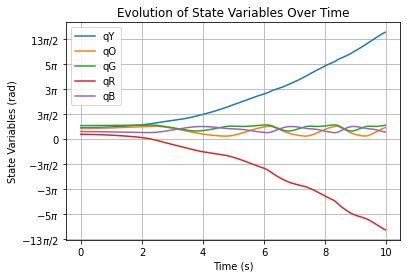

In [30]:
plt.figure()
f,ax=plt.subplots(1)
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['y', 'orange', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '-', '-', '-', '-'])))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("State Variables (rad)")
artists = plt.plot(t,states[:,:5])
plt.title('Evolution of State Variables Over Time')

plt.legend(artists,['qY','qO','qG','qR','qB'])

# Function from https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# Used to make tick marks show in units of pi
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(numpy.round(2 * value / numpy.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

# Makes the tick marks show units of pi
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

Prepare an animation of the mechanism's motion and show some of the frames

2021-04-10 05:17:35,853 - pynamics.output - INFO - calculating outputs
2021-04-10 05:17:35,896 - pynamics.output - INFO - done calculating outputs


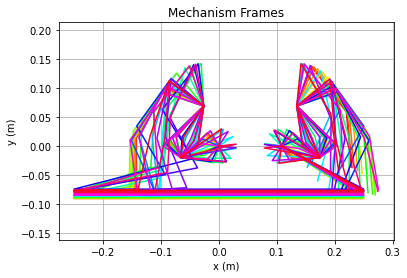

In [31]:
# Make the colors make cycle through a large variety to show each frame
plt.rc('axes', prop_cycle=(plt.cycler('color', plt.cm.hsv(numpy.linspace(0, 1, fps)))))

points_output = PointsOutput(points,system)
y = points_output.calc(states)

points_output.plot_time(tfinal)
plt.title('Mechanism Frames')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

Plot an animation of the mechanism

In [32]:
# Plots final frame of Animation and created object that is used for animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,1,1),linestyle='-') #produces animation using matplotlib
plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.close() # Hide the plot that just shows a single frame of the animation

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

Creating a more easy to read animation (note: this code takes a long time to run. It creates an easier to understand animation, but does not provide any new information from the plot above)

With ground plate shown

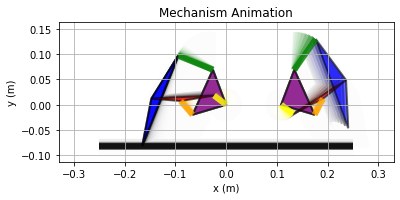

In [33]:

from matplotlib.animation import FuncAnimation

def animate(i):
    # Hacky way to not show show every frame (semitransparent whitebox colors over old frames)
    white = plt.fill([-0.3, -0.3, 0.3, 0.3], [ -0.1, 0.15, 0.15, -0.1], facecolor='white', alpha=0.3)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    purpleLink = plt.fill([ y[i][0,0],  y[i][2,0],  y[i][4,0]], [ y[i][0,1],  y[i][2,1],  y[i][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    redLink = plt.fill([ y[i][1,0],  y[i][3,0],  y[i][6,0]], [ y[i][1,1],  y[i][3,1],  y[i][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    orangeLink = plt.fill([ y[i][2,0],  y[i][3,0]], [ y[i][2,1],  y[i][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    greenLink = plt.fill([ y[i][4,0],  y[i][5,0]], [ y[i][4,1],  y[i][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    yellowLink = plt.fill([ y[i][0,0],  y[i][1,0]], [ y[i][0,1],  y[i][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)
    
    
    # Plate
    plate = plt.fill([ y[i][8,0],  y[i][9,0]], [ y[i][8,1],  y[i][9,1]], edgecolor="black",linewidth=6, alpha=0.8)



    # Right Leg
    # Blue link
    plt.fill([ y[i][17,0],  y[i][16,0],  y[i][15,0]], [ y[i][17,1],  y[i][16,1],  y[i][15,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    plt.fill([ y[i][10,0],  y[i][12,0],  y[i][14,0]], [ y[i][10,1],  y[i][12,1],  y[i][14,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    plt.fill([ y[i][11,0],  y[i][13,0],  y[i][16,0]], [ y[i][11,1],  y[i][13,1],  y[i][16,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    plt.fill([ y[i][12,0],  y[i][13,0]], [ y[i][12,1],  y[i][13,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    plt.fill([ y[i][14,0],  y[i][15,0]], [ y[i][14,1],  y[i][15,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    plt.fill([ y[i][10,0],  y[i][11,0]], [ y[i][10,1],  y[i][11,1]], edgecolor="yellow",linewidth=6, alpha=0.8)



    plt.axis('scaled')
    
    return blueLink

fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=tstep*1000, blit=True)
HTML(anim.to_html5_video())

Without ground plate (in case plate flys off to infinity, see what's going on)

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(i):
    # Hacky way to not show show every frame (semitransparent whitebox colors over old frames)
    white = plt.fill([-0.3, -0.3, 0.3, 0.3], [ -0.1, 0.15, 0.15, -0.1], facecolor='white', alpha=0.3)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Blue link
    blueLink = plt.fill([y[i][7,0],  y[i][6,0],  y[i][5,0]], [ y[i][7,1],  y[i][6,1],  y[i][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    purpleLink = plt.fill([ y[i][0,0],  y[i][2,0],  y[i][4,0]], [ y[i][0,1],  y[i][2,1],  y[i][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    redLink = plt.fill([ y[i][1,0],  y[i][3,0],  y[i][6,0]], [ y[i][1,1],  y[i][3,1],  y[i][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    orangeLink = plt.fill([ y[i][2,0],  y[i][3,0]], [ y[i][2,1],  y[i][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    greenLink = plt.fill([ y[i][4,0],  y[i][5,0]], [ y[i][4,1],  y[i][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    yellowLink = plt.fill([ y[i][0,0],  y[i][1,0]], [ y[i][0,1],  y[i][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

    # Right Leg
    # Blue link
    plt.fill([ y[i][17,0],  y[i][16,0],  y[i][15,0]], [ y[i][17,1],  y[i][16,1],  y[i][15,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
    # Purple link
    plt.fill([ y[i][10,0],  y[i][12,0],  y[i][14,0]], [ y[i][10,1],  y[i][12,1],  y[i][14,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
    # Red link
    plt.fill([ y[i][11,0],  y[i][13,0],  y[i][16,0]], [ y[i][11,1],  y[i][13,1],  y[i][16,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
    # Orange link
    plt.fill([ y[i][12,0],  y[i][13,0]], [ y[i][12,1],  y[i][13,1]], edgecolor="orange",linewidth=6, alpha=0.8)
    # Green link
    plt.fill([ y[i][14,0],  y[i][15,0]], [ y[i][14,1],  y[i][15,1]], edgecolor="green",linewidth=6, alpha=0.8)
    # Yellow link
    plt.fill([ y[i][10,0],  y[i][11,0]], [ y[i][10,1],  y[i][11,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

    plt.axis('scaled')
    
    return blueLink

fig, ax = plt.subplots()

plt.title('Mechanism Animation')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()

anim = FuncAnimation(fig, animate, frames=t.size, interval=tstep*1000, blit=True)
HTML(anim.to_html5_video())